**INNOMATIC RESEARCH LAB -- FINAL PROJECT**

**Plant Disease classification**

**TEAM MEMBERS:**

1.Manuj Kumar Joshi

2.Kashetti Prashanth


3.Priyanka Nandibhatla

4.Soujanya Vattikolla

5.Pooja Roy Choudhary

**INTRODUCTION**

Deep learning models have shown higher performance than machine learning in many fields. Yet, I found it difficult to visualize and understand what is happening behind the layers and activations. It becomes quicly a problem when these models are taken away from the benchmark datasets and need to answer a business case. In my work as a data scientist, I am being challenged with explainability, transparency, and reliability. And even if I have many data points, I often prefer a statistical model to deep learning. This work is a way of challenging my perspective on deep learning and get out of my comfort zone with computer vision

Import and reading 

In [51]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

Data Loading

In [52]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

new-plant-diseases-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [54]:
!unzip \*.zip

Archive:  new-plant-diseases-dataset.zip
replace New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [55]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [80]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv2
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,BatchNormalization,GlobalAveragePooling2D
import tensorflow as tf
import keras
from tensorflow.keras.applications import VGG16
import seaborn as sns


In [7]:
#train_path = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
#valid_path = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [57]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [58]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=5

In [59]:
train_path = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
valid_path = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',
    shuffle=False,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


## Exploratory Data Analysis 

The goal here is to get familiar with our data with visuals and statistics.

How does it look like?

In [77]:
classes = train_path.class_names

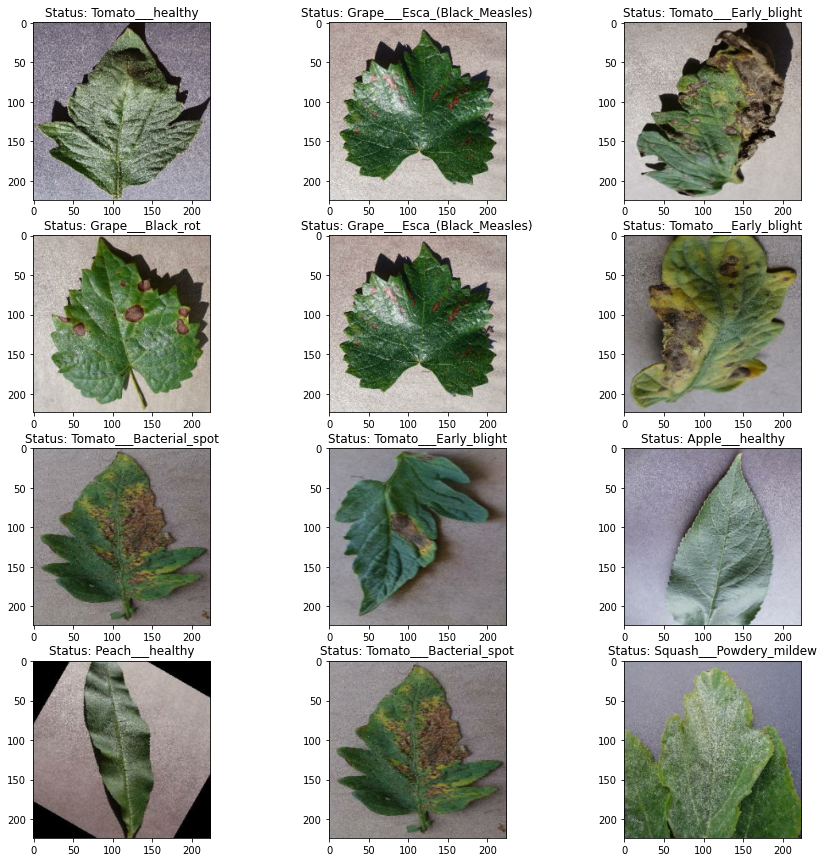

In [78]:
fig,ax=plt.subplots(4,3)
fig.set_size_inches(15,15)
for next_element in train_path:
    x_batch, y_batch = next_element
    for i in range (0,4):
        for j in range(3):
            random_example = np.random.randint(0, BATCH_SIZE)
            ax[i,j].imshow(x_batch[random_example]/250)
            ax[i,j].set_title('Status: '+ classes[y_batch[random_example].numpy()])
    break

We note that the data is already augmented. This is relevant to have a predictive model that generalizes well: the predictions will not be dependent on the quality of the image, or the rotation. Data augmentation in image processing is mainly the following operation on the original image: rotating/flipping, blurring.

Class distribution

In [ ]:
plt.figure(figsize=(14,7))
fig = sns.countplot(x=list_category)
plt.xticks(rotation=85)
plt.title("Class distribution")
plt.xlabel('State')
plt.show()

The classes are uniformly distributed. Let's notice that there are what could be called subclasses: tomatoes disease representation might be closer to each other than apples to tomatoes. For this study, we will ignore it.

Text(0.5, 1.0, 'Distribution of channels: bleu, red, green')

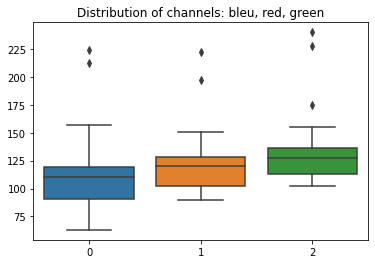

In [85]:
red_values = [np.mean(x_batch[idx][:, :, 0]) for idx in range(BATCH_SIZE)]
green_values = [np.mean(x_batch[idx][:, :, 1]) for idx in range(BATCH_SIZE)]
blue_values = [np.mean(x_batch[idx][:, :, 2]) for idx in range(BATCH_SIZE)]

channels = [blue_values,
            red_values,
            green_values
           ]
sns.boxplot(data=channels)
plt.title("Distribution of channels: bleu, red, green")

Not being used to the computer vision task, it's a bit hard for me to draw any conclusion from the channel distribution. Statistically speaking, the three channels have very comparable distributions.

In [60]:
from tensorflow.keras import models, layers

In [61]:
class_names = train_path.class_names

In [62]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [63]:
import tensorflow_hub as hub

In [64]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 38
feature_extractor_model = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [65]:
model = tf.keras.Sequential([resize_and_rescale,
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(n_classes, activation='softmax')
])
model.build([None, 224, 224, 3]) 
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1280)              4226432   
                                                                 
 dense_5 (Dense)             (None, 38)                48678     
                                                                 
Total params: 4,275,110
Trainable params: 48,678
Non-trainable params: 4,226,432
_________________________________________________________________


In [66]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [67]:
history = model.fit(
    train_path,
    batch_size=BATCH_SIZE,
    validation_data=valid_path,
    verbose=1,
    epochs=5,
)

Epoch 1/5
2197/2197 [==============================] - 222s 98ms/step - loss: 0.2696 - accuracy: 0.9327 - val_loss: 0.1306 - val_accuracy: 0.9594
Epoch 2/5
2197/2197 [==============================] - 215s 98ms/step - loss: 0.0845 - accuracy: 0.9754 - val_loss: 0.0880 - val_accuracy: 0.9722
Epoch 3/5
2197/2197 [==============================] - 215s 98ms/step - loss: 0.0575 - accuracy: 0.9831 - val_loss: 0.0807 - val_accuracy: 0.9726
Epoch 4/5
2197/2197 [==============================] - 215s 97ms/step - loss: 0.0442 - accuracy: 0.9871 - val_loss: 0.0790 - val_accuracy: 0.9729
Epoch 5/5
2197/2197 [==============================] - 214s 97ms/step - loss: 0.0347 - accuracy: 0.9900 - val_loss: 0.0648 - val_accuracy: 0.9779


In [68]:
model.save('/kaggle/working/final_model.h5')

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

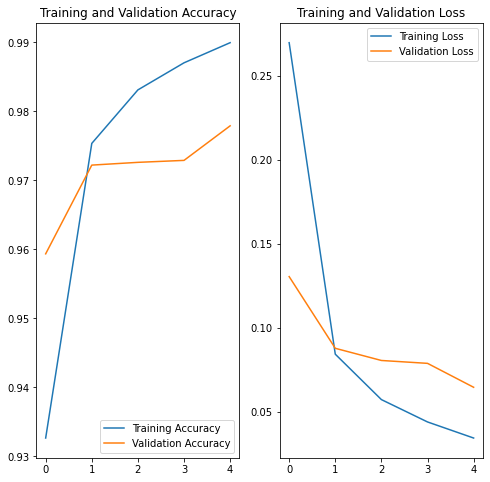

In [70]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [71]:
model.save('/kaggle/working/final_model.h5')

In [72]:
from tensorflow.keras import models, layers
from tensorflow import keras

In [73]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [74]:
plt.figure(figsize=(20, 50))

for count,filename in enumerate(os.listdir("../content/new-plant-diseases-dataset/test/test/")):
    
        
    image_path = "../content/new-plant-diseases-dataset/test/test/"+filename
    new_img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(new_img)
    img = np.expand_dims(img, axis=0)


    #print("Following is our prediction:")
    prediction = model.predict(img)

    d = prediction.flatten()
    j = d.max()
    for index,item in enumerate(d):
        if item == j:
            class_name = class_names[index]

    confidence = round(100 * j, 3)
       
   # plt.figure(figsize = (4,4))
    ax = plt.subplot(8, 5, count + 1)
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(f"A: {filename},\n P: {class_name}.\n Confidence: {confidence}%")

FileNotFoundError: ignored

<Figure size 1440x3600 with 0 Axes>